## 1. Import necessary modules

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [110]:
# beautifying matplotlib output 

import matplotlib_inline

plt.rcParams['font.family'] = 'Source Code Pro', 'serif'
#plt.style.use('./rose-pine-dawn.mplstyle')
#plt.rcParams['figure.dpi'] = 150
#plt.rcParams['savefig.dpi'] = 150

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## 2. Data structures creation

In [111]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]


# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, battery_level=100):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost

## 3. Helper functions

In [112]:
def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points a and b.

    Parameters:
    - a: Tuple representing the x and y coordinates of point a (e.g., (x1, y1))
    - b: Tuple representing the x and y coordinates of point b (e.g., (x2, y2))

    Returns:
    - The Manhattan distance between points a and b.
    """
    (x1, y1) = a
    (x2, y2) = b

    return abs(x1 - x2) + abs(y1 - y2)

#### I. Generate a random grid function

In [113]:
def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])

In [114]:
def generate_environment():
    # define the size of the grid and the probability of an obstacle in each cell
    grid_size = 10
    obstacle_probability = 0.3  # 30% chance of being an obstacle

    # generate a random grid
    grid = generate_random_grid(grid_size, obstacle_probability)

    # define start and goal positions
    start = (3, 2)
    #goal = (grid_size - 1, grid_size - 1)
    goal = (8, 9)

    # ensure start and goal are not obstacles
    grid[start] = 0
    grid[goal] = 0

    # create and return the environment
    return Environment(grid, start, goal), grid


#### II. Visualize the grid and battery using matplotlib

In [115]:
def visualize_grid_and_path(grid, solution_path, trace_battery_levels):
    grid_array = np.array(grid)  # convert grid to numpy array for plotting.

    # create figures for grid/path
    fig_grid, ax_grid = plt.subplots()  # for grid and path

    # plot grid and path
    ax_grid.imshow(grid_array, cmap='Greys', alpha=0.3)  # grid background.

    # highlight start and goal position
    start = solution_path[0]
    goal = solution_path[-1]
    ax_grid.plot(start[1], start[0], color='skyblue', marker='s', markersize=10)  # start position in blue.
    ax_grid.plot(goal[1], goal[0], color='lightgreen', marker='s', markersize=10)  # goal position in green.

    # highlight solution path
    xs, ys = zip(*solution_path)  # extract X and Y coordinates of the path.
    ax_grid.plot(ys, xs, color='salmon', linestyle='-', linewidth=2)  # plot the path in red.
    
    if trace_battery_levels:
        for position, battery_level in trace_battery_levels.items():
            if position != (0, 0) and battery_level == 100:
                ax_grid.text(position[1], position[0], f'BS:\n{battery_level}', ha='center', va='center', color='dimgray')
            else:
                ax_grid.text(position[1], position[0], battery_level, ha='center', va='center', color='dimgray')

    ax_grid.set_title("Grid and Path")

    ax_grid.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax_grid.set_yticks(np.arange(-.5, len(grid), 1), minor=True)

    ax_grid.grid(which="minor", color="dimgray", linestyle='-', linewidth=1)

    ax_grid.tick_params(which="minor", size=0)
    ax_grid.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

    # adjust layout and show plots
    plt.tight_layout()
    plt.show()

## 4. Definiton of Environment and Agent classes

#### I. Environment Class represents the grid and handles state transitions

In [116]:
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # the grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # starting position of the agent.
        self.goal = goal  # goal position the agent aims to reach.

    # returns the possible actions from a given state.
    def possible_actions(self, state):
        possible_actions = ["UP", "DOWN", "LEFT", "RIGHT"]
        x, y = state

        # remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove("UP")
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove("DOWN")
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove("LEFT")
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove("RIGHT")

        return possible_actions

    # returns the state resulting from taking a given action at a given state.
    def state_after_move(self, current_state, action):
        x, y = current_state

        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

#### II. Agent class to traverse inside a world using finding optimal paths

In [117]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state = self.env.initial # initial position of agent in the grid (x, y)
        self.battery_level = 100 # initialize battery at 100%

        self.solution_path = []
        self.trace = {self.env.initial: self.env.initial}
        self.trace_battery_levels = {self.env.initial: self.battery_level}
        self.all_explored_paths = {}


    def reconstruct_path(self, came_from, current):
        path = []

        while current in came_from:
            path.append(current)
            current = came_from[current]

        path.append(self.env.initial)
        path.reverse()
        
        self.solution_path = path


    def shutdown(self):
        # reset all values to default
        self.env.time = 0
        self.state = self.env.initial
        self.battery_level = 100

        self.solution_path = []

        self.trace.clear()
        self.trace = {self.env.initial: self.env.initial}

        self.trace_battery_levels.clear()
        self.trace_battery_levels = {self.env.initial: self.battery_level}

        self.all_explored_paths.clear()
        self.all_explored_paths = {}
       

    # searching algorithms to find the lowest cost path from the initial state to the goal
    # ------------------------------------------------------------------------------------
    def uniform_cost_search(self):
        frontier = PriorityQueue() # priority queue for UCS

        # the start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0) # priority is f-cost, initially the heuristic cost from start to goal

        came_from = {} # tracks the best path to a node
        cost_so_far = {self.env.initial: 0} # tracks the g-cost (cost so far to reach a node)
        

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                self.reconstruct_path(came_from=came_from, current=current_node.state)
                self.trace.update(came_from) # append to trace

                return

            for action in self.env.possible_actions(current_node.state):
                new_state = self.env.state_after_move(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1 # assuming uniform cost for simplicity

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    new_node = Node(state=new_state, parent=current_node, action=action, path_cost=new_cost)

                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state

                    self.all_explored_paths[new_state] = self.all_explored_paths.get(current_node.state, []) + [new_state]

                    if self.trace_battery_levels[current_node.state] <= 0:
                        self.trace_battery_levels[new_state] = 100
                    else:
                        self.trace_battery_levels[new_state] = self.trace_battery_levels[current_node.state] - 10

        return []


    def a_star_search(self):
        frontier = PriorityQueue()

        # the start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0) # priority is f-cost, initially the heuristic cost from start to goal

        came_from = {} # tracks the best path to a node
        cost_so_far = {self.env.initial: 0} # tracks the g-cost (cost so far to reach a node)

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                self.reconstruct_path(came_from, current_node.state)
                self.trace.update(came_from) # append to trace

                return

            for action in self.env.possible_actions(current_node.state):
                new_state = self.env.state_after_move(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1 # assuming uniform cost for simplicity

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(a=new_state, b=self.env.goal) # f(p) = cost(p) + h(n)
                    new_node = Node(state=new_state, parent=current_node, action=action, path_cost=new_cost)

                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state

                    self.all_explored_paths[new_state] = self.all_explored_paths.get(current_node.state, []) + [new_state]

                    if self.trace_battery_levels[current_node.state] <= 0:
                        self.trace_battery_levels[new_state] = 100
                    else:
                        self.trace_battery_levels[new_state] = self.trace_battery_levels[current_node.state] - 10

        return []
    #
    # ------------------------------------------------------------------------------------

## 5. Simulation of the Agent and Environment

In [118]:
def start_simulation(environment: object, grid, algorithm: str = "a_star_search"):
    agent = Agent(environment)
    #agent.shutdown()

    # find the optimum path the agent needs to go in order to reach the goal
    if algorithm == "a_star_search":
        agent.a_star_search()
    else:
        agent.uniform_cost_search()

    solution_path = agent.solution_path
    
    # if there exists a path to the goal
    if solution_path:
        trace = agent.trace
        trace_battery_levels = agent.trace_battery_levels
        
        print("Solution Path:")
        print(solution_path, "\n")

        print("Trace:")
        print(trace, "\n")

        print("Trace Battery Level:")
        print(trace_battery_levels, "\n")

        print("Solution Path length:", len(solution_path))
        print("Trace length:", len(trace))
        print("Trace Battery Level length:", len(trace_battery_levels))
        
        # Visualize the solution
        visualize_grid_and_path(grid=grid, solution_path=solution_path, trace_battery_levels=trace_battery_levels)
        
        return True
    else:
        return False

#### I. Simulation of Uniform-Cost-Search (UCS) pathfinding algorithm

Solution Path:
[(3, 2), (4, 2), (4, 3), (5, 3), (5, 4), (5, 5), (6, 5), (7, 5), (7, 6), (7, 7), (7, 8), (8, 8), (8, 9)] 

Trace:
{(3, 2): (3, 2), (4, 2): (3, 2), (4, 1): (4, 2), (4, 3): (4, 2), (5, 3): (4, 3), (5, 4): (5, 3), (5, 5): (5, 4), (4, 5): (5, 5), (6, 5): (5, 5), (3, 5): (4, 5), (4, 6): (4, 5), (7, 5): (6, 5), (2, 5): (3, 5), (3, 4): (3, 5), (3, 6): (3, 5), (8, 5): (7, 5), (7, 6): (7, 5), (1, 5): (2, 5), (2, 4): (2, 5), (8, 6): (7, 6), (7, 7): (7, 6), (9, 5): (8, 5), (8, 4): (8, 5), (1, 4): (2, 4), (6, 7): (7, 7), (8, 7): (7, 7), (7, 8): (7, 7), (9, 4): (8, 4), (0, 5): (1, 5), (1, 6): (1, 5), (0, 4): (1, 4), (1, 3): (1, 4), (6, 8): (6, 7), (1, 7): (1, 6), (8, 8): (7, 8), (7, 9): (7, 8), (9, 7): (8, 7), (9, 3): (9, 4), (9, 8): (8, 8), (8, 9): (8, 8), (1, 2): (1, 3), (5, 8): (6, 8), (6, 9): (6, 8), (2, 7): (1, 7)} 

Trace Battery Level:
{(3, 2): 100, (4, 2): 90, (4, 1): 80, (4, 3): 80, (5, 3): 70, (5, 4): 60, (5, 5): 50, (4, 5): 40, (6, 5): 40, (3, 5): 30, (4, 6): 30, (7, 5): 3

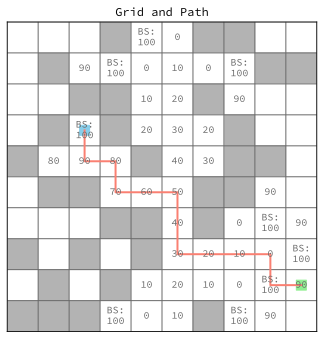

In [119]:
environment, grid = generate_environment()

if not start_simulation(environment=environment, grid=grid, algorithm="uniform_cost_search"):
    print("No path to the goal is found in the current environment!")
    print("Simulation failed!")

#### II. Simulation of A* (A Star) pathfinding algorithm

Solution Path:
[(3, 2), (4, 2), (4, 3), (5, 3), (5, 4), (5, 5), (6, 5), (7, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9)] 

Trace:
{(3, 2): (3, 2), (4, 2): (3, 2), (4, 1): (4, 2), (4, 3): (4, 2), (5, 3): (4, 3), (5, 4): (5, 3), (5, 5): (5, 4), (4, 5): (5, 5), (6, 5): (5, 5), (7, 5): (6, 5), (8, 5): (7, 5), (7, 6): (7, 5), (9, 5): (8, 5), (8, 4): (8, 5), (8, 6): (8, 5), (7, 7): (7, 6), (8, 7): (8, 6), (6, 7): (7, 7), (7, 8): (7, 7), (9, 7): (8, 7), (8, 8): (8, 7), (6, 8): (7, 8), (7, 9): (7, 8), (9, 8): (8, 8), (8, 9): (8, 8), (6, 9): (7, 9)} 

Trace Battery Level:
{(3, 2): 100, (4, 2): 90, (4, 1): 80, (4, 3): 80, (5, 3): 70, (5, 4): 60, (5, 5): 50, (4, 5): 40, (6, 5): 40, (7, 5): 30, (8, 5): 20, (7, 6): 20, (9, 5): 10, (8, 4): 10, (8, 6): 10, (7, 7): 10, (8, 7): 0, (6, 7): 0, (7, 8): 0, (9, 7): 100, (8, 8): 100, (6, 8): 100, (7, 9): 100, (9, 8): 90, (8, 9): 90, (6, 9): 90} 

Solution Path length: 13
Trace length: 26
Trace Battery Level length: 26


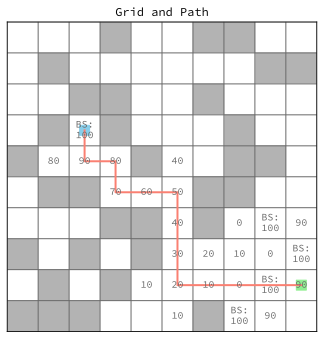

In [120]:
if not start_simulation(environment=environment, grid=grid, algorithm="a_star_search"):
    print("No path to the goal is found in the current environment!")
    print("Simulation failed!")